# Main Program for LSTM with Dropout

Main program to train the parameters except leaf temperature.

Author: Efraim Manurung

MSc Thesis in Information Technology Group, Wageningen University

efraim.manurung@gmail.com

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Multiply, Add, Layer, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Layer to subtract from 1
class SubtractFromOne(Layer):
    def call(self, inputs):
        return 1.0 - inputs

# Custom Layer to extract a specific feature (replacing Lambda layers that slice inputs)
class ExtractFeature(Layer):
    def __init__(self, index, **kwargs):
        super(ExtractFeature, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

def r2_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure y_pred is float32
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def train_and_evaluate_lstm_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    mgh_data = pd.read_excel("output_simulated_data_train_lstm.xlsx")
    features = ['Timesteps [5 minutes]', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted DNN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], -1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], -1, X_test.shape[1]))

    if flag_train:
        time_steps = X_train_reshaped.shape[1]
        features_count = X_train_reshaped.shape[2]

        # Define the input layer with the appropriate shape
        input_layer = Input(shape=(time_steps, features_count), name='input_layer')

        # First LSTM layer with 64 units and dropout
        lstm_output_1 = LSTM(units=64, return_sequences=True)(input_layer)
        dropout_1 = Dropout(0.2)(lstm_output_1)

        # Second LSTM layer with 32 units and dropout
        lstm_output_2 = LSTM(units=32, return_sequences=True)(dropout_1)
        dropout_2 = Dropout(0.2)(lstm_output_2)

        # Third LSTM layer with 16 units and dropout
        lstm_output_3 = LSTM(units=16, return_sequences=False)(dropout_2)
        dropout_3 = Dropout(0.2)(lstm_output_3)

        # Dense layer followed by dropout
        w_physics = Dense(1, activation='sigmoid')(dropout_3)

        # Custom layer to subtract from 1
        w_DNN = SubtractFromOne()(w_physics)

        # Extract specific features
        q_physics_input = ExtractFeature(index=1, name='q_physics_input')(input_layer)
        q_DNN_input = ExtractFeature(index=2, name='q_DNN_input')(input_layer)

        # Calculate the final output
        y_hat_physics = Multiply()([q_physics_input, w_physics])
        y_hat_DNN = Multiply()([q_DNN_input, w_DNN])
        y_hat = Add()([y_hat_physics, y_hat_DNN])

        # Create the model
        model = Model(inputs=input_layer, outputs=y_hat)
        
        adam = Adam(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
        
        model.compile(optimizer=adam, loss='mse', metrics=['mae', r2_score_metric])

        history = model.fit(X_train_reshaped, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save model architecture and weights
        model_json = model.to_json()
        with open(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.weights.h5")

        # Predict the test set after training
        y_hat_test = model.predict(X_test_reshaped)

    else:
        # Load model architecture and weights
        with open(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.json", "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={'r2_score_metric': r2_score_metric, 'SubtractFromOne': SubtractFromOne, 'ExtractFeature': ExtractFeature})

        loaded_model.load_weights(f"lstm-dropout-models/{target_variable.replace(' ', '_')}_lstm_model.weights.h5")
        loaded_model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Predict the test set using the loaded model
        y_hat_test = loaded_model.predict(X_test_reshaped)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()



Epoch 1/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4528 - mae: 0.4667 - r2_score_metric: -12.1253 - val_loss: 0.1888 - val_mae: 0.3322 - val_r2_score_metric: 0.8001
Epoch 2/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1892 - mae: 0.3241 - r2_score_metric: -4.3701 - val_loss: 0.1980 - val_mae: 0.3306 - val_r2_score_metric: 0.7990
Epoch 3/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1823 - mae: 0.3236 - r2_score_metric: -2.8824 - val_loss: 0.1836 - val_mae: 0.3329 - val_r2_score_metric: 0.7962
Epoch 4/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1757 - mae: 0.3161 - r2_score_metric: -66.5963 - val_loss: 0.1849 - val_mae: 0.3349 - val_r2_score_metric: 0.7957
Epoch 5/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1958 - mae: 0.3346 - r2_score_metric: 0.7380 - val_loss: 0.1818 - val_mae: 0.3269 - val_r2_score_metric: 0.8022
Epoch 6/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1858 - mae: 0.3251 - r2_score_metric: -2.5866 - val_los

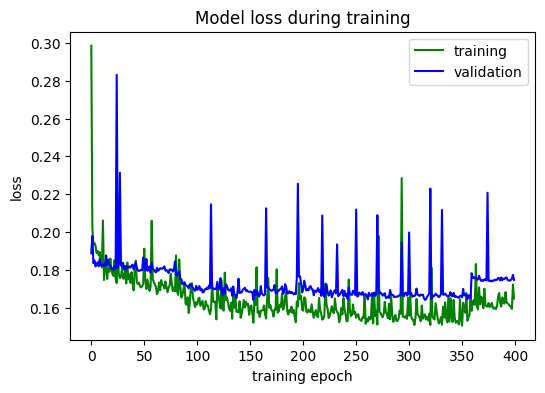

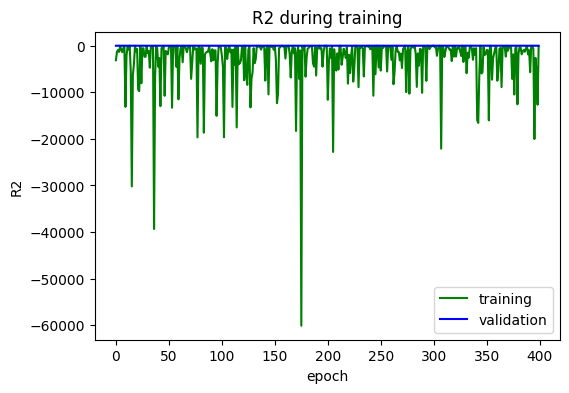

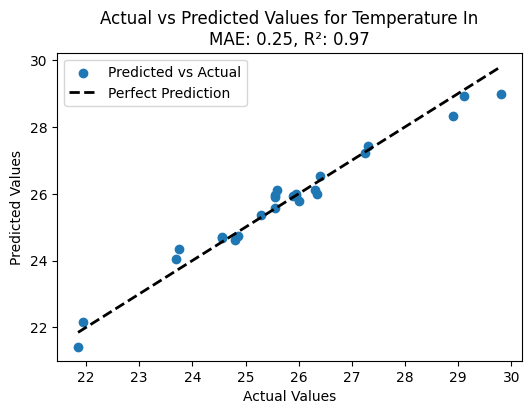

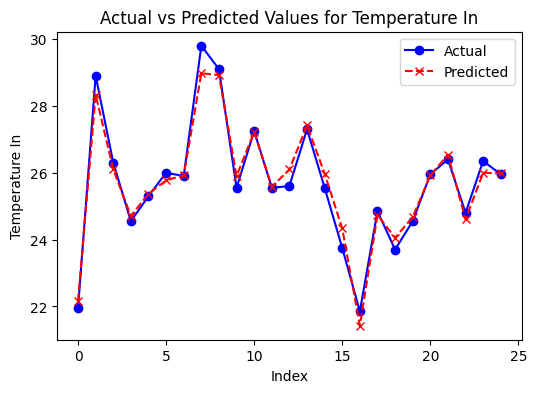

Epoch 1/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 27.6212 - mae: 3.1168 - r2_score_metric: -529.6279 - val_loss: 4.7120 - val_mae: 1.7233 - val_r2_score_metric: 0.8091
Epoch 2/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.8318 - mae: 1.7229 - r2_score_metric: -2.7219 - val_loss: 4.6527 - val_mae: 1.7064 - val_r2_score_metric: 0.8156
Epoch 3/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9814 - mae: 1.7261 - r2_score_metric: -8.7794 - val_loss: 4.5911 - val_mae: 1.6914 - val_r2_score_metric: 0.8191
Epoch 4/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8302 - mae: 1.7333 - r2_score_metric: -651.8987 - val_loss: 4.4474 - val_mae: 1.6642 - val_r2_score_metric: 0.8213
Epoch 5/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8893 - mae: 1.7139 - r2_score_metric: -21.1427 - val_loss: 4.6105 - val_mae: 1.6909 - val_r2_score_metric: 0.8205
Epoch 6/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.8280 - mae: 1.7148 - r2_score_metric: -470.2411 - v

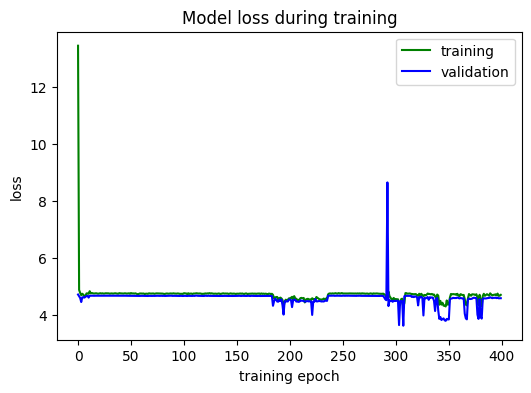

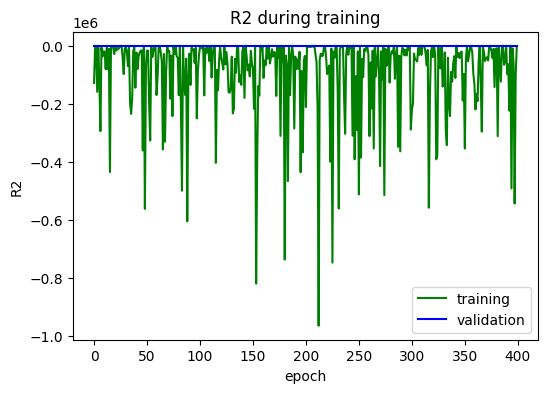

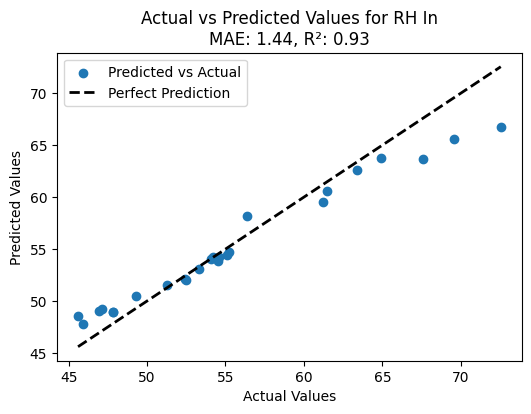

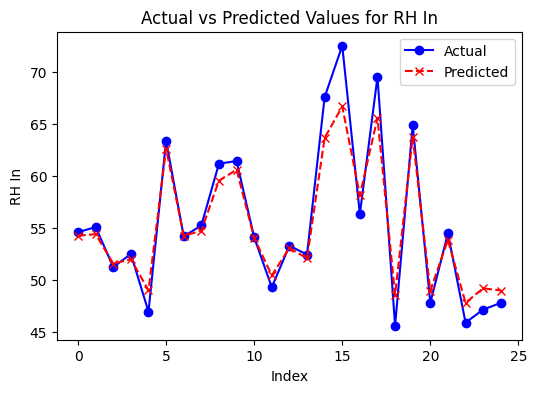

Epoch 1/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 45.9600 - mae: 2.5864 - r2_score_metric: -218.2957 - val_loss: 7.5865 - val_mae: 1.1795 - val_r2_score_metric: 0.2976
Epoch 2/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 14.1596 - mae: 1.3268 - r2_score_metric: -28.7092 - val_loss: 7.4996 - val_mae: 1.1399 - val_r2_score_metric: 0.3467
Epoch 3/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 12.0093 - mae: 1.2981 - r2_score_metric: -770.0812 - val_loss: 7.4720 - val_mae: 1.1378 - val_r2_score_metric: 0.3493
Epoch 4/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 10.5821 - mae: 1.2439 - r2_score_metric: -19681.0547 - val_loss: 7.4418 - val_mae: 1.1397 - val_r2_score_metric: 0.3463
Epoch 5/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 14.2641 - mae: 1.3371 - r2_score_metric: -60560.2852 - val_loss: 7.4152 - val_mae: 1.1370 - val_r2_score_metric: 0.3497
Epoch 6/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 13.7020 - mae: 1.2939 - r2_score_m

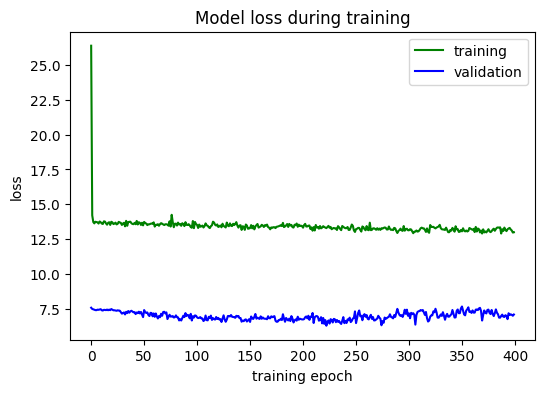

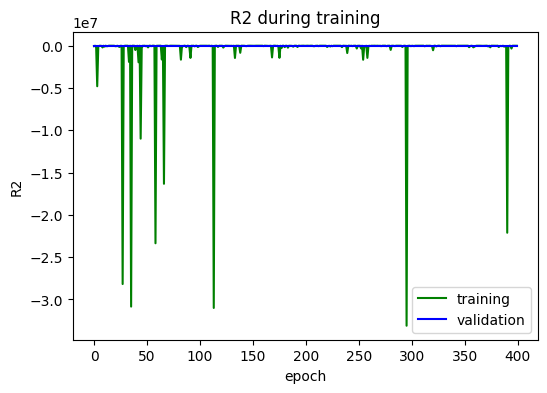

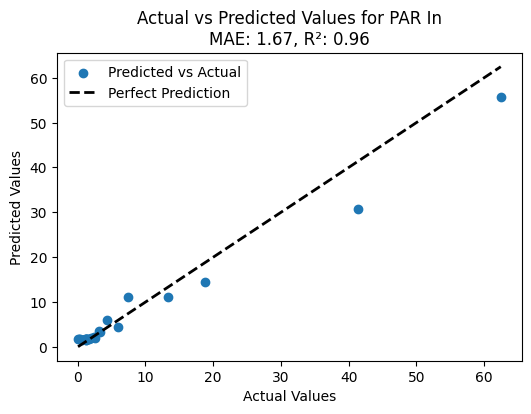

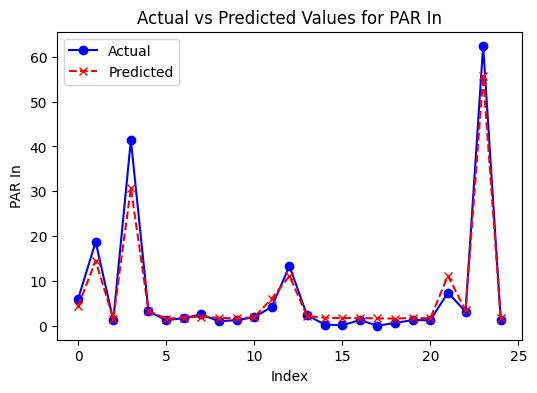

Epoch 1/400


TypeError: Input 'y' of 'Sub' Op has type float32 that does not match type int64 of argument 'x'.

In [2]:
target_variable = ['Temperature In', 'RH In', 'PAR In', 'CO2 In']

for i in target_variable:
    train_and_evaluate_lstm_model(i, flag_train=True, _epochs=400, _batch_size=4)

Epoch 1/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.6767 - mae: 1.5473 - r2_score_metric: -107066496.0000 - val_loss: 2.3420 - val_mae: 1.5197 - val_r2_score_metric: -93298000.0000
Epoch 2/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3128 - mae: 1.5102 - r2_score_metric: -92511328.0000 - val_loss: 2.3447 - val_mae: 1.5207 - val_r2_score_metric: -93405576.0000
Epoch 3/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3422 - mae: 1.5208 - r2_score_metric: -93689224.0000 - val_loss: 2.3424 - val_mae: 1.5201 - val_r2_score_metric: -93312832.0000
Epoch 4/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3345 - mae: 1.5185 - r2_score_metric: -93377952.0000 - val_loss: 2.3402 - val_mae: 1.5194 - val_r2_score_metric: -93223488.0000
Epoch 5/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.3122 - mae: 1.5116 - r2_score_metric: -92486432.0000 - val_loss: 2.3428 - val_mae: 1.5203 - val_r2_score_metric: -93328056.0000
Epoch 6/400
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 

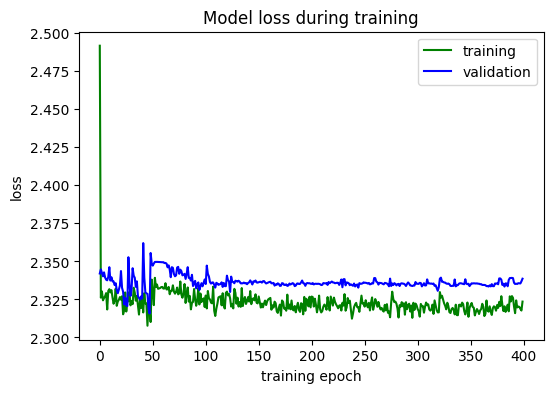

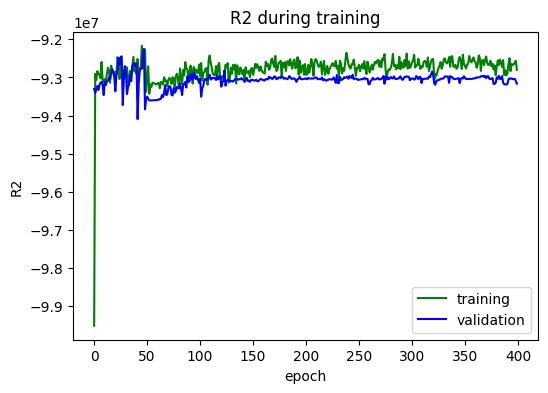

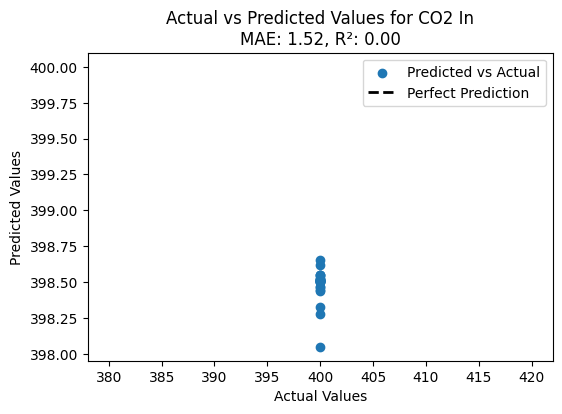

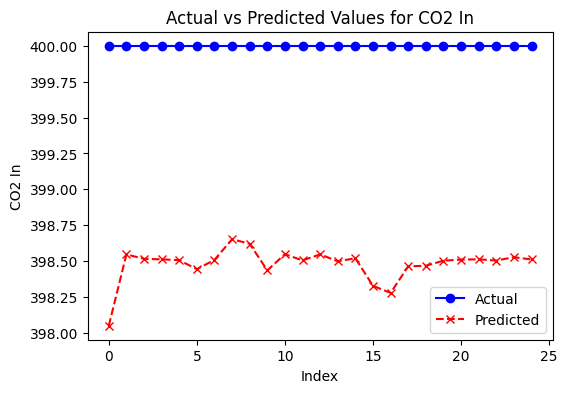

In [5]:
train_and_evaluate_lstm_model('CO2 In', flag_train=True, _epochs=400, _batch_size=4)